In [1]:
import os
import sys

# For Jupyter notebooks, add the parent directory to sys.path
notebook_dir = os.getcwd()  # Get current working directory
parent_dir = os.path.dirname(notebook_dir)  # Get parent directory
sys.path.append(parent_dir)  # Add parent directory to path

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Base Metric
from metrics.part_aware.region import PartCC
# tools
from metrics.tools.labelling import label

import warnings

warnings.filterwarnings("ignore")

# Testing Code

In [2]:
from scipy.ndimage import distance_transform_edt

from metrics.tools.connected_components import gpu_connected_components
from metrics.tools.utils import METRIC_FUNCS
from metrics.tools.utils import _handle_empty_classes, _calculate_final_score

def stuff_cls_scores(pred_one_hot_cc, gt_one_hot_cc, metric='dsc', stuff_cls_list=None):
    """
    Calculate quality score for stuff classes (semantic segments)
    
    Inputs:
        pred_one_hot_cc: One-hot encoded prediction tensor
        gt_one_hot_cc: One-hot encoded ground truth tensor
    
    Args:
        metric: Metric name to use for comparison
        stuff_cls_list: List of stuff class indices to process
        
    Returns:
        mean_score: Mean quality score across all specified stuff classes
        
    Note: 
        If stuff_cls_list is None or empty, returns 0
    """
    total_score = 0.0
    
    if not stuff_cls_list:
        return 0.0
    
    for cls_idx in stuff_cls_list:
        pred_one_hot_cc[cls_idx] = torch.clamp(pred_one_hot_cc[cls_idx], 0, 1)
        gt_one_hot_cc[cls_idx] = torch.clamp(gt_one_hot_cc[cls_idx], 0, 1)
        score = METRIC_FUNCS[metric](pred_one_hot_cc[cls_idx], gt_one_hot_cc[cls_idx])
        total_score += score
    
    mean_score = total_score / len(stuff_cls_list)
    return mean_score

def dilate_mask(mask):
    """
    Dilate a binary mask by 1 pixel
    
    Inputs:
        mask: Binary mask tensor
    
    Returns:
        dilated: Dilated binary mask
    """
    import torch.nn.functional as F
    mask_f = mask.float().unsqueeze(0).unsqueeze(0)
    kernel = torch.ones((1, 1, 3, 3), device=mask.device)
    dilated = F.conv2d(mask_f, kernel, padding=1) > 0
    return dilated.squeeze(0).squeeze(0)

def process_part_metrics(region_mask, dilated_region_mask, pred_one_hot_cc, gt_one_hot_cc, part_cls, metric):
    """
    Process metrics for a specific part class within a region
    
    Inputs:
        region_mask: Binary mask for the current region
        dilated_region_mask: Dilated binary mask for better part detection
    
    Args:
        pred_one_hot_cc: One-hot encoded prediction tensor
        gt_one_hot_cc: One-hot encoded ground truth tensor
        part_cls: Part class index to process
        metric: Metric name to use for comparison
        
    Returns:
        part_score: Score for this part class if parts exist, None otherwise
        pred_part_mask: Binary mask for prediction parts
        gt_part_mask: Binary mask for ground truth parts
    """
    pred_part = pred_one_hot_cc[part_cls]
    gt_part = gt_one_hot_cc[part_cls]
    
    pred_part_mask = torch.zeros_like(region_mask, dtype=torch.bool)
    gt_part_mask = torch.zeros_like(region_mask, dtype=torch.bool)
    
    for part_label in torch.unique(pred_part)[1:]:
        part_mask = pred_part == part_label
        if torch.any(torch.logical_and(dilated_region_mask, part_mask)):
            pred_part_mask = torch.logical_or(pred_part_mask, part_mask)
    
    for part_label in torch.unique(gt_part)[1:]:
        part_mask = gt_part == part_label
        if torch.any(torch.logical_and(dilated_region_mask, part_mask)):
            gt_part_mask = torch.logical_or(gt_part_mask, part_mask)
    
    if torch.any(pred_part_mask) and torch.any(gt_part_mask):
        if metric == 'nsd':
            pred_full = torch.zeros_like(region_mask, dtype=torch.float32)
            gt_full = torch.zeros_like(region_mask, dtype=torch.float32)
            
            pred_full[pred_part_mask] = 1.0
            gt_full[gt_part_mask] = 1.0
            
            part_score = METRIC_FUNCS[metric](pred_full, gt_full)
        else:
            part_score = METRIC_FUNCS[metric](pred_part_mask.float(), gt_part_mask.float())
        
        return part_score, pred_part_mask, gt_part_mask
    
    return None, pred_part_mask, gt_part_mask

def process_region(region_label, region_mask, gt_cc, pred_one_hot_cc, gt_one_hot_cc, class_idx, metric, part_cls_list, results):
    """
    Process a single region for the region-based metric
    
    Inputs:
        region_label: Label of the current region
        region_mask: Binary mask for the current region
    
    Args:
        gt_cc: Ground truth connected components
        pred_one_hot_cc: One-hot encoded prediction tensor
        gt_one_hot_cc: One-hot encoded ground truth tensor
        class_idx: Class index being processed
        metric: Metric name to use for comparison
        part_cls_list: List of part class indices
        results: Dictionary to store results
        
    Returns:
        region_score: Score for this region
        region_part_scores: Dictionary of part scores for this region
    """
    pred_region = pred_one_hot_cc[class_idx][region_mask]
    gt_region = gt_one_hot_cc[class_idx][region_mask]

    pred_region = torch.clamp(pred_region, 0, 1)
    gt_region = torch.clamp(gt_region, 0, 1)
    
    if metric == 'nsd':
        pred_full = torch.zeros_like(region_mask, dtype=torch.float32)
        gt_full = torch.zeros_like(region_mask, dtype=torch.float32)
        
        pred_full[region_mask] = pred_region.float()
        gt_full[region_mask] = gt_region.float()
        
        region_score = METRIC_FUNCS[metric](pred_full, gt_full)
    else:
        region_score = METRIC_FUNCS[metric](pred_region.float(), gt_region.float())

    print(f"Class {class_idx}, Region {region_label}: {region_score.item()}")
    
    results["class_metrics"][class_idx]["region_scores"][region_label] = region_score.item()
    
    region_part_scores = {}
    if part_cls_list is not None:
        dilated_region_mask = dilate_mask(region_mask)
        
        for part_cls in part_cls_list:
            part_score, _, _ = process_part_metrics(
                region_mask, dilated_region_mask, 
                pred_one_hot_cc, gt_one_hot_cc, 
                part_cls, metric
            )
            
            if part_score is not None:
                print(f"Class {class_idx}, Region {region_label}, Part {part_cls}: {part_score.item()}")

                if part_cls not in results["class_metrics"][class_idx]["part_scores"]:
                    results["class_metrics"][class_idx]["part_scores"][part_cls] = {}
                
                part_score_value = part_score.item()
                results["class_metrics"][class_idx]["part_scores"][part_cls][region_label] = part_score_value
                region_part_scores[part_cls] = part_score_value
    
    return region_score, region_part_scores

def region_based_metric(pred_one_hot_cc, gt_one_hot_cc, metric='dsc', thing_cls_list=None, part_cls_list=None):
    """
    Calculate region-based metrics between predicted and ground truth segmentations
    
    Inputs:
        pred_one_hot_cc: One-hot encoded prediction tensor (C, H, W) or (C, H, W, D)
        gt_one_hot_cc: One-hot encoded ground truth tensor (C, H, W) or (C, H, W, D)
    
    Args:
        metric: Metric name to use for comparison
        thing_cls_list: List of "thing" class indices to process
        part_cls_list: List of part class indices to evaluate within thing regions
        
    Returns:
        final_score: Combined thing and stuff score
        
    Note:
        Each ground truth region is evaluated separately against predictions
        All part instances within a single "thing" instance are treated collectively
    """
    results = {
        "class_metrics": {},
        "overall_score": 0.0
    }
    
    num_classes = pred_one_hot_cc.shape[0]
    if thing_cls_list is None:
        all_classes = set(range(1, num_classes))
        part_classes = set(part_cls_list or [])
        thing_cls_list = list(all_classes - part_classes)
    
    total_metric_score = []
    
    for class_idx in thing_cls_list:
        results["class_metrics"][class_idx] = {
            "region_scores": {},
            "part_scores": {}
        }
        
        score, handled = _handle_empty_classes(pred_one_hot_cc[class_idx], gt_one_hot_cc[class_idx])
        if handled:
            total_metric_score += score
            results["class_metrics"][class_idx]["score"] = score
            continue
        
        gt_cc, num_gt_regions = gpu_connected_components(gt_one_hot_cc[class_idx])
        
        for region_label in range(1, num_gt_regions + 1):
            region_mask = (gt_cc == region_label)
            
            region_score, region_part_scores = process_region(
                region_label, region_mask, gt_cc, 
                pred_one_hot_cc, gt_one_hot_cc, 
                class_idx, metric, part_cls_list, results
            )

            print(f"Class {class_idx}, Region {region_label} Score: {region_score.item()}")
            
            if region_part_scores:
                all_scores = [region_score.item()] + list(region_part_scores.values())
                combined_score = sum(all_scores) / len(all_scores)
                
                if "combined_scores" not in results["class_metrics"][class_idx]:
                    results["class_metrics"][class_idx]["combined_scores"] = {}
                results["class_metrics"][class_idx]["combined_scores"][region_label] = combined_score

                total_metric_score.append(combined_score)
                print(f"Class {class_idx}, Region {region_label} Combined Score: {combined_score}")
                print()
            else:
                total_metric_score.append(region_score.item())
                print(f"Class {class_idx}, Region {region_label} Combined Score: {region_score.item()}")
                print()
                
    stuff_score = stuff_cls_scores(pred_one_hot_cc, gt_one_hot_cc, metric, thing_cls_list)
    print('Stuff score:', stuff_score)

    thing_score = sum(total_metric_score) / len(total_metric_score) if total_metric_score else 0.0
    print('Total thing score:', total_metric_score)
    print('Thing score:', thing_score)

    return (stuff_score + thing_score) / 2.0 #! Simple 1:1 weighted average for now. This can be changed.

def get_gt_regions(gt, device):
    """
    Divide ground truth segmentation space into regions based on proximity to instances
    
    Inputs:
        gt: Ground truth segmentation for a single class
        device: Device to place tensors on
    
    Returns:
        region_map: Tensor where each pixel is labeled with the nearest region ID
        num_features: Number of distinct regions/connected components
        
    Note:
        Uses distance transforms to create a Voronoi-like partition of the image space
    """
    gt_cc, num_features = gpu_connected_components(gt)
    
    distance_map = torch.zeros_like(gt, dtype=torch.float32)
    region_map = torch.zeros_like(gt, dtype=torch.long)

    for region_label in range(1, num_features + 1):
        region_mask = (gt_cc == region_label)
        region_mask_np = region_mask.cpu().numpy()
        distance = torch.from_numpy(distance_transform_edt(~region_mask_np)).to(device)
        
        if region_label == 1 or distance_map.max() == 0:
            distance_map = distance
            region_map = region_label * torch.ones_like(gt, dtype=torch.long)
        else:
            update_mask = distance < distance_map
            distance_map[update_mask] = distance[update_mask]
            region_map[update_mask] = region_label

    return region_map, num_features

# Case Details

In [3]:
# Dummy Case
pred = torch.zeros((30, 30)).cuda()
gt = torch.zeros((30, 30)).cuda()

# Stuff Classes first (lowest hirearchy)
pred[1:30, 1:30] = 4

# Thing Classes next (medium hirearchy)
pred[1:6, 1:6] = 1
pred[7:20, 7:20] = 1
pred[22:27, 22:27] = 3

# Part Classes last (highest hirearchy)
pred[2:5, 2:5] = 2
pred[2:5, 8:10] = 2
pred[8:12, 8:12] = 2
pred[14:19, 14:19] = 2
pred[10:15, 22:25] = 2

# Same ordering for ground truth
# Stuff Classes first
gt[1:30, 1:30] = 4

# Thing Classes next
gt[1:6, 1:6] = 1
gt[7:20, 7:20] = 1
gt[22:27, 22:27] = 3

# Part Classes last
gt[2:5, 2:5] = 2
gt[14:19, 14:19] = 2

# Class definitions
stuff_cls_list = [4]
thing_cls_list = [1, 3]
part_cls_list = [2]

#! Unfortunately, I am not sure how to avoid defining this hierarchy style thing. But we dont need to because the output is expected to be in hierarchy already

# Visualise sample case

In [4]:
def plot_case(pred, gt, stuff_cls_list, thing_cls_list, part_cls_list, class_names_dict=None):

    sns.set(style="whitegrid", context="talk")
    plt.rcParams["axes.edgecolor"] = "0.2"
    plt.rcParams["axes.linewidth"] = 1.5

    pred_np = pred.cpu().numpy() if hasattr(pred, "cpu") else pred
    gt_np = gt.cpu().numpy() if hasattr(gt, "cpu") else gt

    all_classes = sorted(set(thing_cls_list + part_cls_list + stuff_cls_list))
    max_class_id = max(all_classes) + 1  # max possible ID + 1

    background_color = [0.97, 0.97, 0.97, 1]
    pastel_colors = [
        [0.85, 0.41, 0.43, 1.0],
        [0.88, 0.58, 0.40, 1.0],
        [0.92, 0.77, 0.5, 1.0],
        [0.6, 0.75, 0.55, 1.0],
        [0.55, 0.67, 0.83, 1.0],
        [0.65, 0.5, 0.75, 1.0],
        [0.75, 0.55, 0.75, 1.0],
        [0.7, 0.9, 0.9, 1.0],
    ]

    # Create color mapping that works with any class IDs
    class_colors = [background_color] * max_class_id  # Initialize with background color
    color_idx = 0
    for class_id in all_classes:
        if color_idx < len(pastel_colors):
            class_colors[class_id] = pastel_colors[color_idx]
        else:
            # Generate additional colors if needed
            h = (color_idx * 0.618033988749895) % 1  # Golden ratio method for color distribution
            r, g, b = plt.cm.hsv(h)
            class_colors[class_id] = [r, g, b, 1.0]
        color_idx += 1
    
    # Custom colormap for class visualization
    class_cmap = mcolors.ListedColormap(class_colors)
    
    # Custom normalization to map each class ID to its specific color
    class_bounds = np.arange(-0.5, max_class_id + 0.5, 1)
    class_norm = mcolors.BoundaryNorm(class_bounds, len(class_colors))

    # TP / FP / FN Confusion map colors
    tp_color = [0.77, 0.60, 0.43, 1.0]  # True Positive
    fp_color = [0.95, 0.70, 0.80, 1.0]  # False Positive
    fn_color = [0.85, 0.71, 0.85, 1.0]  # False Negative

    # Create confusion visualization
    confusion_vis = np.zeros_like(pred_np)
    confusion_colors = [background_color] * (3 * max_class_id)  # Initialize with background

    # For each class, set colors for TP, FP, FN
    for i, c in enumerate(all_classes):
        # Find TP, FP, FN for each class
        tp = (pred_np == c) & (gt_np == c)
        fp = (pred_np == c) & (gt_np != c)
        fn = (pred_np != c) & (gt_np == c)

        # Set values in confusion visualization
        confusion_vis[tp] = c
        confusion_vis[fp] = c + max_class_id
        confusion_vis[fn] = c + 2 * max_class_id

        # Set colors for each case
        confusion_colors[c] = tp_color
        confusion_colors[c + max_class_id] = fp_color
        confusion_colors[c + 2 * max_class_id] = fn_color

    confusion_cmap = mcolors.ListedColormap(confusion_colors)
    confusion_bounds = np.arange(-0.5, 3 * max_class_id + 0.5, 1)
    confusion_norm = mcolors.BoundaryNorm(confusion_bounds, len(confusion_colors))

    # Create figure with 3 subplots
    fig, ax = plt.subplots(1, 3, figsize=(30, 8))
    plt.subplots_adjust(wspace=0.4)

    # Plot prediction, ground truth, and confusion map
    ax[0].imshow(pred_np, cmap=class_cmap, norm=class_norm, interpolation="nearest")
    ax[0].set_title("Prediction")

    ax[1].imshow(gt_np, cmap=class_cmap, norm=class_norm, interpolation="nearest")
    ax[1].set_title("Ground Truth")

    ax[2].imshow(confusion_vis, cmap=confusion_cmap, norm=confusion_norm, interpolation="nearest")
    ax[2].set_title("Confusion Map")

    # Format axes with grids
    for a in ax:
        h, w = pred_np.shape
        a.set_xticks(np.arange(-0.5, w, 1), minor=True)
        a.set_yticks(np.arange(-0.5, h, 1), minor=True)
        a.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
        a.tick_params(which='minor', bottom=False, left=False)
        a.set_xticks([])
        a.set_yticks([])
        for spine in a.spines.values():
            spine.set_visible(True)
            spine.set_color("#dddddd")

    # Create legend
    if class_names_dict is None:
        class_names_dict = {cid: f"Class {cid}" for cid in all_classes}

    color_legend_patches = [
        plt.Line2D([0], [0], marker='s', color='w', label=class_names_dict[cid],
                   markerfacecolor=tuple(class_colors[cid][:3]), markersize=15)
        for cid in all_classes
    ]
    ax[1].legend(handles=color_legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()

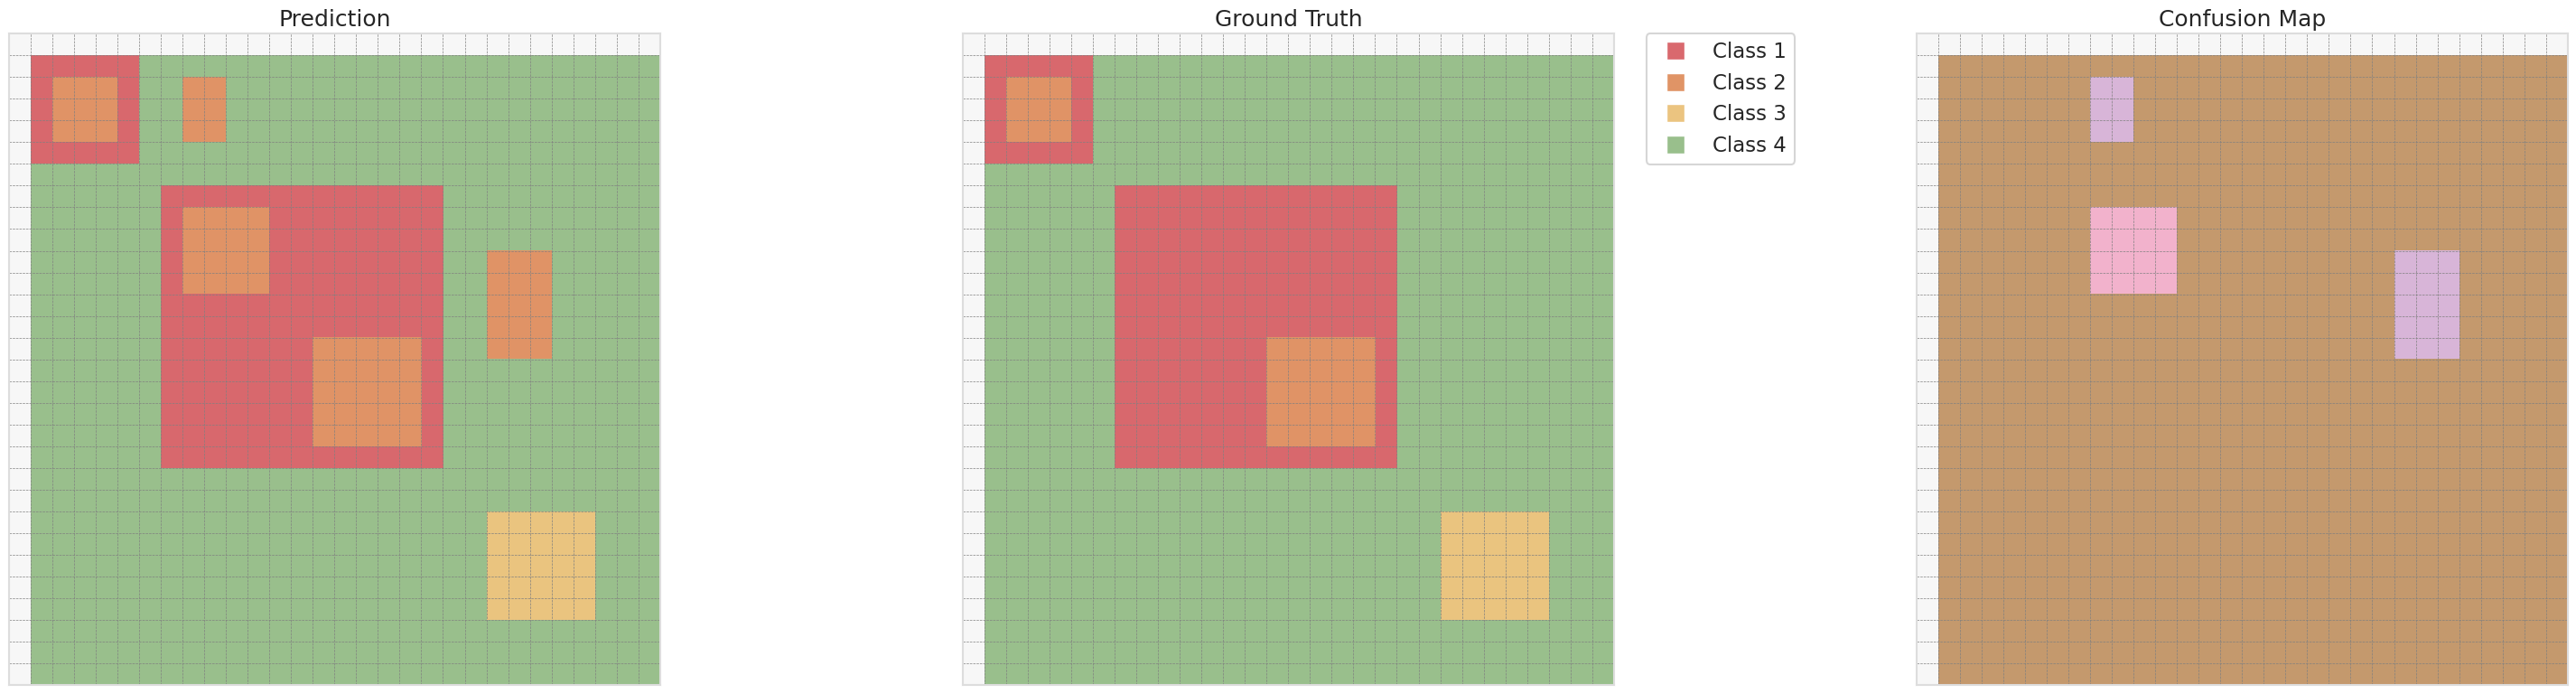

In [5]:
plot_case(pred, gt, stuff_cls_list=stuff_cls_list, thing_cls_list=thing_cls_list, part_cls_list=part_cls_list)

# Labelling the inputs

In [6]:
pred_one_hot_cc = label(pred, 5)
gt_one_hot_cc = label(gt, 5)

In [7]:
# Comparing with complete function:
indirect_part_pq_verification = region_based_metric(
    pred_one_hot_cc=pred_one_hot_cc,
    gt_one_hot_cc=gt_one_hot_cc,
    metric='dsc', # Make sure this matches the metric used throughout
    # stuff_cls_list=stuff_cls_list,
    thing_cls_list=thing_cls_list,
    part_cls_list=part_cls_list
)
print(indirect_part_pq_verification)
#! I am not sure yet why there is a minor difference in stuff scores between regpart and partpq.

Class 1, Region 1: 1.0
Class 1, Region 1, Part 2: 1.0
Class 1, Region 1 Score: 1.0
Class 1, Region 1 Combined Score: 1.0

Class 1, Region 2: 0.9411764740943909
Class 1, Region 2, Part 2: 0.7575757503509521
Class 1, Region 2 Score: 0.9411764740943909
Class 1, Region 2 Combined Score: 0.8493761122226715

Class 3, Region 1: 1.0
Class 3, Region 1 Score: 1.0
Class 3, Region 1 Combined Score: 1.0

Stuff score: tensor(0.9737, device='cuda:0')
Total thing score: [1.0, 0.8493761122226715, 1.0]
Thing score: 0.9497920374075571
tensor(0.9617, device='cuda:0')


In [8]:
# Comparing with complete function:
direct_part_pq_verification = PartCC(
    pred_one_hot_cc=pred_one_hot_cc,
    gt_one_hot_cc=gt_one_hot_cc,
    metric='dsc', # Make sure this matches the metric used throughout
    # stuff_cls_list=stuff_cls_list,
    thing_cls_list=thing_cls_list,
    part_cls_list=part_cls_list
)
print(direct_part_pq_verification)
#! I am not sure yet why there is a minor difference in stuff scores between regpart and partpq.

tensor(0.9617, device='cuda:0')
